In [104]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import torch.nn as nn 
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import gzip
import numpy as np
from pathlib import Path

In [59]:
mnist_dir = Path(os.getcwd()) / Path("MNIST/raw/")
dataset_dir = []
for dirs in os.listdir(mnist_dir):
    dataset_dir.append(mnist_dir / dirs)
    
images_dir = [dataset_dir[0], dataset_dir[2]]
labels_dir = [dataset_dir[1], dataset_dir[3]]
images_dir, labels_dir

([WindowsPath('d:/material/Machine_Deep/github_repos/AI_/AI/DL/Vision/Visualizing_CNN/MNIST/raw/t10k-images-idx3-ubyte.gz'),
  WindowsPath('d:/material/Machine_Deep/github_repos/AI_/AI/DL/Vision/Visualizing_CNN/MNIST/raw/train-images-idx3-ubyte.gz')],
 [WindowsPath('d:/material/Machine_Deep/github_repos/AI_/AI/DL/Vision/Visualizing_CNN/MNIST/raw/t10k-labels-idx1-ubyte.gz'),
  WindowsPath('d:/material/Machine_Deep/github_repos/AI_/AI/DL/Vision/Visualizing_CNN/MNIST/raw/train-labels-idx1-ubyte.gz')])

In [60]:
f = gzip.open(images_dir[0],'r')
metadata = f.read(16)

In [61]:
import struct

# Unpack the bytes into integers
magic_number = struct.unpack('>i', metadata[:4])[0]
num_images = struct.unpack('>i', metadata[4:8])[0]
num_rows = struct.unpack('>i', metadata[8:12])[0]
num_cols = struct.unpack('>i', metadata[12:16])[0]

# Print the values
print("Magic Number:", magic_number)
print("Number of Images:", num_images)
print("Number of Rows:", num_rows)
print("Number of Columns:", num_cols)


Magic Number: 2051
Number of Images: 10000
Number of Rows: 28
Number of Columns: 28


In [66]:
def extract_images(file_path, num_images = 60_000):

    f = gzip.open( file_path,'r')
    image_size = 28
    metadata = f.read(16)
    buf = f.read(image_size * image_size * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, image_size, image_size, 1)
    return data

def extract_labels(file_path, num_labels = 60_000):

    f = gzip.open(file_path,'r')
    f.read(8)  
    buf = f.read(num_labels)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels


In [263]:
train_images = extract_images(images_dir[1], 60_000)
train_labels = extract_labels(labels_dir[1], 60_000)

test_images = extract_images(images_dir[0], 10_000)
test_labels = extract_labels(labels_dir[0], 10_000)


# Converting to torch
train_images = torch.from_numpy(train_images)
train_labels = torch.from_numpy(train_labels)

test_images = torch.from_numpy(test_images)
test_labels = torch.from_numpy(test_labels)

# Resizing according to PyTorch conventions
train_images = train_images.swapaxes(1, 3)
test_images = test_images.swapaxes(1, 3)

In [132]:
class CustomDataset(Dataset):
    def __init__(self,
                 dataset,
                 labels,
                 transform = None):
        
        self.images = dataset
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):

        image = self.images[index]
        if self.transform:
            image =  self.transform(self.images[index])
        
        return (image, self.labels[index])
    
    def __len__(self):
        return len(self.images)

## Making dataset and dataloader

In [214]:
BATCH_SIZE = 128

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
train_dataset = CustomDataset(dataset=train_images,
                              labels=train_labels,
                              transform=train_transform)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)


In [183]:
image = torch.ones((1, 3, 5, 5))
model = nn.Sequential(
    nn.Conv2d(in_channels=3,
              out_channels=6,
              kernel_size=2,
              stride=1,
              padding=0)
)
print(model(image).shape)
torch.numel(model[0].weight) + torch.numel(model[0].bias)

torch.Size([1, 6, 4, 4])


78

In [184]:
image = torch.ones((1, 3, 5, 5))
model = nn.Sequential(
    nn.Conv2d(in_channels=3,
              out_channels=6,
              kernel_size=2,
              stride=1,
              padding=0,
              groups=3)
)
print(model(image).shape)
torch.numel(model[0].weight) + torch.numel(model[0].bias)

torch.Size([1, 6, 4, 4])


30

In [208]:
class Classification(nn.Module):
    def __init__(self,
                 in_channels = 1):
        
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=in_channels * 2,
                      kernel_size=3,
                      stride=2,
                      padding=0,
                      groups=in_channels),
            nn.BatchNorm2d(num_features=in_channels * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=in_channels*2,
                      out_channels=in_channels * 4,
                      kernel_size=3,
                      stride=2,
                      padding=0,
                      groups=in_channels * 2),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(144, 16),
            nn.Linear(16, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.block1(x)


In [209]:
model = Classification()
model(train_dataset[0][0].unsqueeze(0))

tensor([[0.0825, 0.1011, 0.0807, 0.1093, 0.0881, 0.1074, 0.0990, 0.1160, 0.1296,
         0.0863]], grad_fn=<SoftmaxBackward0>)

In [215]:
def train(model,
          dataloader,
          optimizer,
          epochs,
          loss_fn):
    model.train()
    for epoch in range(epochs):
        for images, labels in dataloader:
            predictios = model(images)
            loss = loss_fn(predictios, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 3 == 0:
            print(f"Loss -> {loss.item():.4f}")

            

In [216]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

In [217]:
train(model=model,
      dataloader=train_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=10)

Loss -> 1.6707
Loss -> 1.6936
Loss -> 1.6458
Loss -> 1.6397


In [228]:
torch.argmax(model(train_dataset[200][0].unsqueeze(0)))

tensor(1)

In [227]:
train_dataset[200][1]

tensor(1)

# Visualizing the outputs

In [238]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [254]:
model

Classification(
  (block1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), groups=2)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=144, out_features=16, bias=True)
    (7): Linear(in_features=16, out_features=10, bias=True)
    (8): Softmax(dim=1)
  )
)

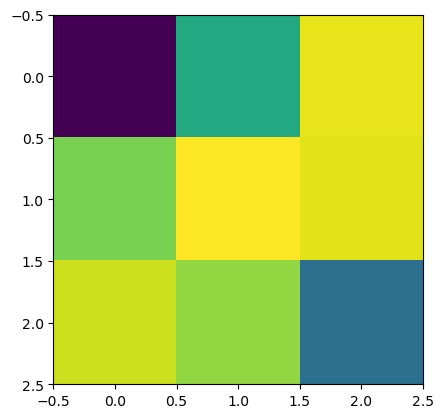

In [285]:
plt.imshow(model.block1[0].weight[0].detach().T)
plt.imshow(model.block1[0].weight[1].detach().T)

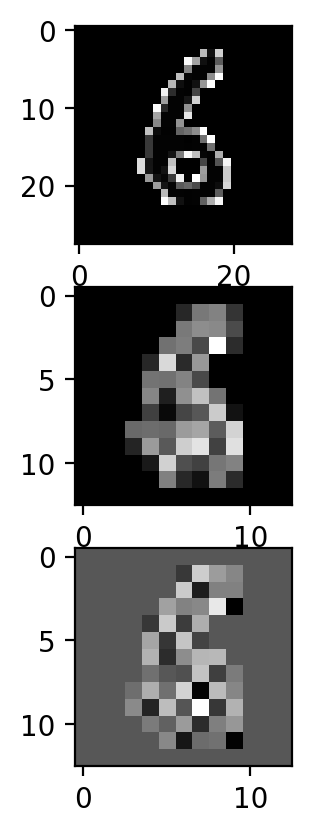

In [277]:
image = train_dataset[1020][0]

l1_f1 = model.block1[0](image)[0]
l1_f2 = model.block1[0](image)[1]

fig, axes = plt.subplots(nrows=3, dpi=200)

axes[0].imshow(image.T, cmap="gray")
axes[1].imshow(l1_f1.unsqueeze(0).T.detach().numpy(), cmap="gray")
axes[2].imshow(l1_f2.unsqueeze(0).T.detach().numpy(), cmap="gray")

## Will be better for RGB inputs